## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from math import sqrt, pi

## Question 3

#### Function Definitions

In [2]:
def MultivariateNormal(X, mu, cov):
    
# Calculates pdf value for a given value, multivaraite normal distribution parameters
# Inputs:
#     X ----> Datapoints 
#     mu ---> Mean of the multivaraite normal distribution 
#     cov --> Covaraince matrix of the multivaraite normal distribution
# Returns:
#     pdf 

    try:
        k = X.shape[1]
    except:
        X = X.reshape(1,-1)
        k = X.shape[1]
    sf = sqrt(np.linalg.det(cov)*(2*pi)**k)
    exp_val = np.array(np.sum(np.multiply(np.matmul((X - mu), np.linalg.inv(cov)), (X - mu)), axis = 1), dtype=np.longdouble)
   
    pdf = np.exp(-exp_val/2)/sf
    return pdf
    

In [3]:
def BayesClassifier(X, classes, mean_MLE, cov_MLE, prior, Loss_matrix='default'):

# Classifies the given datapoints using the BayesClassifier
# Inputs:
#     X ---------------> Datapoints 
#     classes ---------> Possible classes to which X can belong 
#     mean_MLE --------> MLE estimates of the mean of each class
#     prior -----------> prior probability of all the classes
#     cov_MLE ---------> MLE estimates of the covaraince matrix of each class
#     Loss_matrix -----> Loss matrix (default value is used if this is not passed in the function call)
# Returns:
#     Y_pred ----------> Predicted classes

    n_classes = len(classes)
    N = X.shape[0]
    d = X.shape[1]
       
    if Loss_matrix =='default':
        Loss_matrix = np.ones((n_classes,n_classes))
        np.fill_diagonal(Loss_matrix, 0)
        
    posterior = np.zeros((N, n_classes))    
    for c in classes:
        q = MultivariateNormal(X, mean_MLE[c], cov_MLE[c])*prior[c]
        
        posterior[:,c] = q

    g = np.zeros((N, n_classes))
    for i in classes:
        g[:,i] = np.dot(posterior, Loss_matrix[i,:])
    
    Y_pred = np.argmin(g, axis=1)
    
    return Y_pred 
    

In [4]:
def accuracy(Y_true, Y_pred):
    
# Returns the accuracy of predicted classes
# Inputs:
#     Y_true -----> True class labels
#     Y_pred -----> Predicted class labels
# Returns:
#     tp/N -------> Accuracy of predicted class labels 

    tp = len(np.argwhere(Y_true==Y_pred))
    N  = Y_true.shape[0]
    return tp/N

#### Part (a)

#### Generating Training points

In [5]:
mu1  = np.zeros(3)
mu2 = np.array([1, 5, -3])
mu3 = np.zeros(3)

mu = [mu1, mu2, mu3]

cov1 = np.diag([3, 5, 2])
cov2 = np.array([[1, 0 , 0], [0, 4, 1], [0, 1, 6]])
cov3 = 10*np.identity(3)

cov = [cov1, cov2, cov3]

In [6]:
np.random.seed(0)
n_classes = len(mu)
d = len(mu1)
num_train = 20

X_train = np.zeros((n_classes*num_train, d))
for i in range(n_classes):
    X_train[(i)*num_train:(i+1)*num_train,:] = np.random.multivariate_normal(mu[i], cov[i], num_train)

Y_train = np.array([0]*num_train + [1]*num_train + [2]*num_train)
order = list(range(n_classes*num_train))
np.random.shuffle(order)

X_train = X_train[order,:]
Y_train = Y_train[order]

In [7]:
classes = np.unique(Y_train)

mean_MLE = []
cov_MLE  = []
N = len(Y_train)

for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    mean_MLE.append(np.mean(x_c, axis = 0))
    cov_MLE.append(np.cov(x_c.T)*N/(N-1))
    

table = []
headers = ["Class", "Estimated\nmean", "Actual\nMean", "Estimated\nCovariance", "Actual\nCovarinace"]

 
    
for i in range(n_classes):
    table.append([i+1, mean_MLE[i], mu[i], cov_MLE[i], cov[i]])

print(tabulate(table, headers, tablefmt = 'fancy_grid'))


╒═════════╤═══════════════════════════════════════╤════════════╤═════════════════════════════════════════╤═════════════════╕
│   Class │ Estimated                             │ Actual     │ Estimated                               │ Actual          │
│         │ mean                                  │ Mean       │ Covariance                              │ Covarinace      │
╞═════════╪═══════════════════════════════════════╪════════════╪═════════════════════════════════════════╪═════════════════╡
│       1 │ [ 0.3392595   0.61656112 -0.34167993] │ [0. 0. 0.] │ [[3.24175107 0.15192638 0.38377377]     │ [[3 0 0]        │
│         │                                       │            │  [0.15192638 6.84813478 0.18501716]     │  [0 5 0]        │
│         │                                       │            │  [0.38377377 0.18501716 1.98197715]]    │  [0 0 2]]       │
├─────────┼───────────────────────────────────────┼────────────┼─────────────────────────────────────────┼─────────────────┤


#### Part (b)

In [8]:
n_pts = 1500
alpha = np.linspace(0, 1, n_pts)
# alpha = alpha[1:n_pts-1]

prior = np.array([1/n_classes]*3)
cov_common = np.sum(np.array([p*cov for p,cov in zip(prior,cov_MLE)]), axis = 0)
cov_shrunk = []

cov_alpha = []
for a in alpha:
    cov_alpha.append(list(map(lambda c: ((1-a)*num_train*c + a*num_train*n_classes*cov_common)/((1-a)*num_train + a*num_train*n_classes), cov_MLE)))

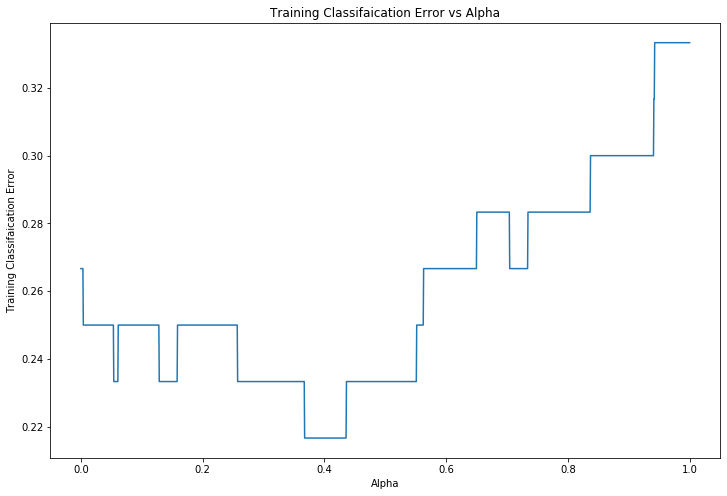

Training error is lowest for alpha  = 0.3676


In [9]:
Y_train_pred_alpha  = []
train_error_alpha = []
for cov_ in cov_alpha:
    Y_train_pred = BayesClassifier(X_train, np.arange(n_classes), mean_MLE, cov_, prior, Loss_matrix='default')
    Y_train_pred_alpha.append(Y_train_pred)
    train_error_alpha.append(1 - accuracy(Y_train, Y_train_pred))

plt.figure(figsize=(12,8))   
plt.plot(alpha, train_error_alpha)
plt.title('Training Classifaication Error vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Training Classifaication Error')
plt.show()

print('Training error is lowest for alpha  = {}'.format(round(alpha[np.argmin(train_error_alpha)], 4)))


#### Part (c)

In [10]:
num_test = 50

X_test = np.zeros((n_classes*num_test, d))
for i in range(n_classes):
    X_test[(i)*num_test:(i+1)*num_test,:] = np.random.multivariate_normal(mu[i], cov[i], num_test)

Y_test = np.array([0]*num_test + [1]*num_test + [2]*num_test)
order = list(range(n_classes*num_test))
np.random.shuffle(order)

X_test = X_test[order,:]
Y_test = Y_test[order]

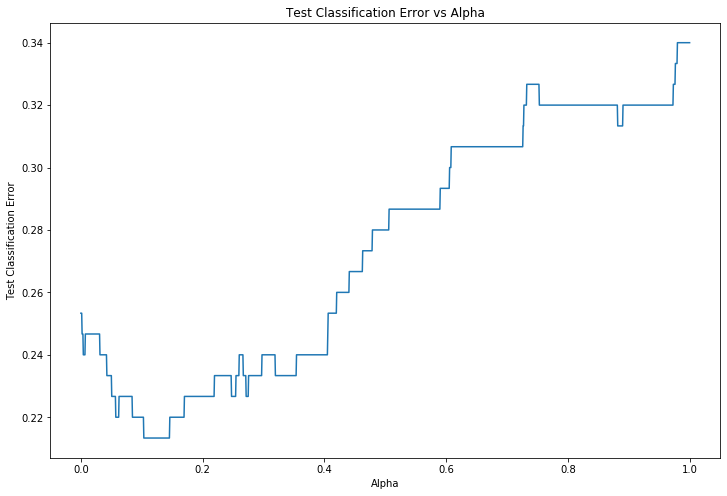

Test error lowest for alpha  = 0.1034


In [11]:
Y_test_pred_alpha  = []
test_error_alpha = []
for cov_ in cov_alpha:
    Y_test_pred = BayesClassifier(X_test, np.arange(n_classes), mean_MLE, cov_, prior, Loss_matrix='default')
    Y_test_pred_alpha.append(Y_test_pred)
    test_error_alpha.append(1 - accuracy(Y_test, Y_test_pred))

plt.figure(figsize=(12,8))   
plt.plot(alpha, test_error_alpha)
plt.title('Test Classification Error vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Test Classification Error')
plt.show()

print('Test error lowest for alpha  = {}'.format(round(alpha[np.argmin(test_error_alpha)], 4)))
